In [1]:
import astropy.io.fits as fits
import pylab as pl
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
def bx(cat, rmin=19., rmax=24.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin = np.ones(len(cat), dtype=bool)

    cat['u-g'] = cat['u'] - cat['g']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['u-g'] >  0.0
    isin &= cat['u-g'] <  3.0
    isin &= cat['g-r'] > -0.5
    isin &= cat['g-r'] <  1.0
    isin &= cat['u-g'] >  1.0 + 2.3 * (cat['g-r'] - 0.35)

    # isin &= ((cat['g-r'] < 0.25) & (cat['u-g'] < 1.2)) | (cat['u-g'] >= 1.2)
    # isin &= ((cat['g-r'] < 0.15) & (cat['u-g'] < 1.0)) | (cat['u-g'] >= 1.0)
    
    isin  = isin & (cat['r'] > rmin)
    isin  = isin & (cat['r'] < rmax)
    
    isin  = isin & (~liu_udrops(cat, band='r', magmin=rmin, maglim=rmax))

    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['u'] > 0.0)
    isin = isin & (cat['g'] > 0.0)
    
    return  isin

In [3]:
def liu_udrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    u-drop color selection.
    '''

    # Check these targets have u band imaging available. 
    # assert  np.all(clauds['FLAG_FIELD_BINARY'][:,1] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    
    isin = isin & (clauds['u'] - clauds['g'] > 0.88)
    isin = isin & (clauds['u'] - clauds['g'] > 1.99 * (clauds['g'] - clauds['r']) + 0.68)

    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (clauds['u'] > 0.0)
    isin = isin & (clauds['g'] > 0.0)
    isin = isin & (clauds['r'] > 0.0)
    
    return  isin

In [4]:
def gdrop(cat, imin=18., imax=25.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['r-i'] = cat['r'] - cat['i']
    cat['g-r'] = cat['g'] - cat['r']

    # https://arxiv.org/pdf/1704.06004.pdf
    isin &= cat['g-r'] >  1.0
    isin &= cat['r-i'] <  1.0    
    isin &= cat['g-r'] >  1.5 * cat['r-i'] + 0.8
    
    isin  = isin & (cat['i'] > imin)
    isin  = isin & (cat['i'] < imax)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['g'] > 0.0)
    isin = isin & (cat['r'] > 0.0)
    isin = isin & (cat['i'] > 0.0)
    
    # Exclude where we have u imaging
    # isin = isin & (cat['FLAG_FIELD_BINARY'][:,1] == False)
        
    return  isin

# Load parent LBGLAE

In [5]:
dat = Table.read('/global/cscratch1/sd/mjwilson/secondary/sv1/raw/Mar21/LBG_LBGLAE.fits')

In [6]:
dat.pprint()

   ID           RA                DEC         MASK ... H_ERR     KS   KS_ERR
------- ------------------ ------------------ ---- ... ------ ------- ------
2583147 150.75933271574516  0.983195946873128    0 ... 1000.0 -99.008 1000.0
 573916 150.86911633369758  3.426048659419034    0 ... 1000.0 -99.006 1000.0
2780988 149.50564681564768   1.85035147374792    0 ...  0.038  22.842  0.031
 531718  150.7392966994768 3.0388757335261487    0 ... 1000.0 -99.007 1000.0
4284702  150.1982722567504  2.540242923257786    0 ...  0.017  21.643  0.019
3304418 148.88704835035935  2.860288849123229    0 ... 1000.0 -99.008 1000.0
4867461  149.4769176608476 2.7146748082853858    0 ...   0.08   22.03   0.28
5242180 151.10482625165122  2.821128757377072    0 ... 1000.0 -99.009 1000.0
2604067 150.77116917897175 1.2011132416614745    0 ... 1000.0 -99.008 1000.0
3913049  150.7108549121019  2.544422091021527    0 ...  0.001  18.408  0.002
    ...                ...                ...  ... ...    ...     ...    ...

In [7]:
dat

ID,RA,DEC,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [7],EB_V,FUV_err,NUV_err,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE,U,U_ERR,US,US_ERR,G,G_ERR,R,R_ERR,I,I_ERR,Z,Z_ERR,Y,Y_ERR,YV,YV_ERR,J_ERR,H_ERR,KS,KS_ERR
int64,float64,float64,int16,int16,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int32,bytes9,int64,float64,float32,float32,float32,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2583147,150.75933271574516,0.983195946873128,0,7,True .. False,0.020819177342490044,-99.0,-99.0,-13.69,-13.808,-14.48,-14.7,-15.219,-15.461,-15.581,-15.644,-15.699,-15.714,-15.717,-15.828,-15.589,-99.0,0.02,11,8.99221,50.9027,54.8312,2,49,1,0.0426,0.0069,0.0694,-99.0,0.04,0.0426,0.0426,2,10000,2068,CLAUDS-BX,4339,0.8743910704931016,0.0,0.0,0.0,False,22.057,0.0,21.957,0.006,21.166,0.001,20.873,0.001,20.758,0.002,20.693,0.002,20.675,0.005,-99.025,1000.0,1000.0,1000.0,-99.008,1000.0
573916,150.86911633369758,3.426048659419034,0,7,True .. False,0.017170668097478598,-99.0,-99.0,-11.494,-13.077,-15.089,-15.398,-16.249,-16.484,-16.555,-16.717,-16.782,-16.799,-16.813,-16.943,-16.715,-99.0,0.0834,11,279.852,105.382,39.3204,2,63,30,0.08,0.0664,0.0936,-99.0,3.08,0.08,0.08,1,10000,39966,CLAUDS-U,109,0.307109878015725,0.0,0.0,0.0,False,23.183,0.005,22.978,0.012,21.631,0.002,21.278,0.002,21.216,0.002,21.093,0.002,21.007,0.005,-99.021,1000.0,1000.0,1000.0,-99.006,1000.0
2780988,149.50564681564768,1.85035147374792,0,95,True .. True,0.017389397440208332,-99.0,-99.0,-22.063,-22.078,-22.229,-22.387,-22.964,-22.988,-23.023,-23.097,-23.148,-23.158,-23.136,-23.207,-22.948,-99.0,3.3102,11,12.2932,353.556,34.894,2,143,24,3.2946,3.2518,3.328,-99.0,3.24,3.2946,3.2946,2,10000,11155,CLAUDS-U,119,0.11247313705618422,0.0,0.0,0.0,False,28.852,0.893,26.3,0.129,24.071,0.01,23.598,0.008,23.558,0.01,23.523,0.014,23.628,0.031,23.624,0.026,0.034,0.038,22.842,0.031
531718,150.7392966994768,3.0388757335261487,0,7,True .. False,0.0180709168628438,-99.0,-99.0,-13.7,-14.546,-15.959,-16.257,-17.069,-17.27,-17.305,-17.375,-17.44,-17.454,-17.452,-17.559,-17.326,-99.0,0.0635,11,269.345,73.1368,13.3639,1,51,30,0.06,0.0464,0.0736,-99.0,3.0,0.06,0.06,1,10000,34204,CLAUDS-U,118,0.6347785534909552,0.0,0.0,0.0,False,21.481,0.001,21.358,0.002,20.104,0.0,19.828,0.0,19.794,0.0,19.752,0.001,19.697,0.001,-99.022,1000.0,1000.0,1000.0,-99.007,1000.0
4284702,150.1982722567504,2.540242923257786,0,127,True .. True,0.015768861470084283,-99.0,-99.0,-23.224,-23.356,-23.632,-23.719,-24.03,-24.1,-24.183,-24.282,-24.332,-24.343,-24.374,-24.435,-24.16,-99.0,3.0909,11,19.9142,130.281,57.546,33,143,25,3.0902,3.0691,3.111,-99.0,3.3,3.0902,3.0902,10,10000,11155,CLAUDS-U,117,0.9673266517128524,0.0,0.0,0.0,False,25.181,0.126,24.395,0.047,22.894,0.012,22.337,0.009,22.201,0.009,22.168,0.014,22.234,0.028,22.383,0.016,0.018,0.017,21.643,0.019
3304418,148.88704835035935,2.860288849123229,0,3,True .. False,0.02280842908644172,-99.0,-99.0,-17.931,-18.62,-19.742,-19.966,-20.688,-21.127,-21.459,-21.717,-21.851,-21.895,-22.045,-22.298,-22.178,-99.0,0.3128,11,2.64537,124.341,9.10963,29,99,21,0.3136,0.2969,0.3328,-99.0,0.32,0.3136,0.3136,9,10000,39965,CLAUDS-U,116,0.6120128892578972,0.0,0.0,0.0,False,27.419,1000.0,27.713,1000.0,20.986,0.002,20.094,0.001,19.735,0.001,19.301,0.001,19.381,0.002,-99.028,1000.0,1000.0,1000.0,-99.008,1000.0
4867461,149.4769176608476,2.7146748082853858,0,31,True .. False,0.017

# Exclude duplicates from parent.

In [8]:
dups = Table.read('/global/cscratch1/sd/mjwilson/DESILBG/tomog/lbglae-matches.fits')

In [9]:
exclude = np.isin(dat['ID'], dups['ID'])

dat = dat[~exclude]

In [10]:
# Check unique targets.
np.all(np.unique(dat['ID']) == np.sort(dat['ID']))

True

(-1.0, 6.5)

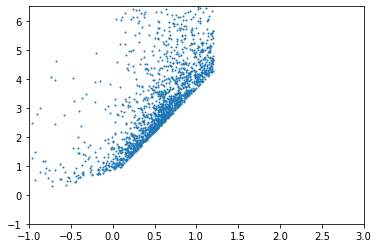

In [11]:
isin = dat['SAMPLE'] == 'CLAUDS-U'

pl.plot(dat['G'][isin] - dat['R'][isin], dat['U'][isin] - dat['R'][isin], marker='.', lw=0.0, markersize=2)

pl.xlim(-1., 3.0)
pl.ylim(-1., 6.5)

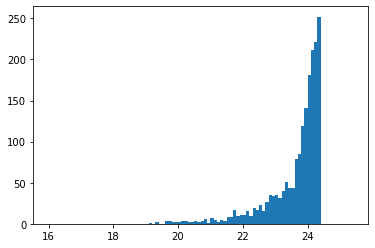

In [12]:
_ = pl.hist(dat['R'][isin], bins=np.arange(16., 25.5, 0.1))

(-1.0, 6.5)

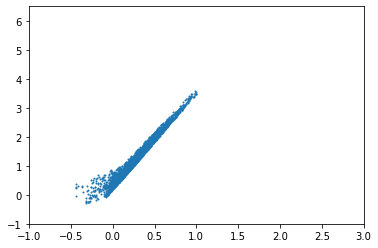

In [13]:
isin = dat['SAMPLE'] == 'CLAUDS-BX'

pl.plot(dat['G'][isin] - dat['R'][isin], dat['U'][isin] - dat['R'][isin], marker='.', lw=0.0, markersize=2)

pl.xlim(-1., 3.0)
pl.ylim(-1., 6.5)

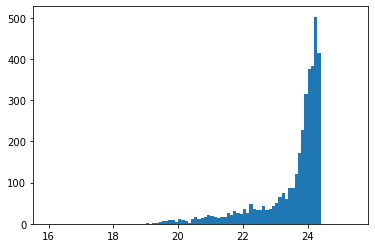

In [14]:
_ = pl.hist(dat['R'][isin], bins=np.arange(16., 25.5, 0.1))

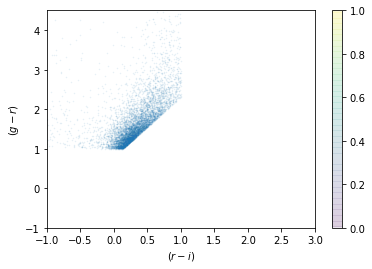

In [15]:
isin = dat['SAMPLE'] == 'CLAUDS-G'

pl.scatter(dat['R'][isin] - dat['I'][isin], dat['G'][isin] - dat['R'][isin], marker='.', alpha=0.1, label='', s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

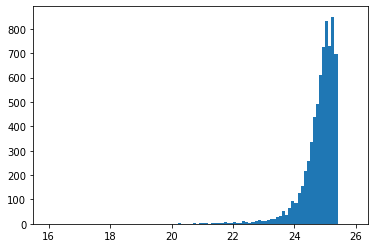

In [16]:
_ = pl.hist(dat['I'][isin], bins=np.arange(16., 26., 0.1))

In [17]:
len(dat)

12597

Text(0.5, 0, 'Z')

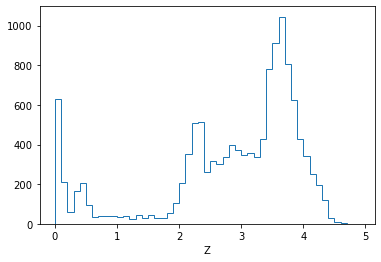

In [18]:
pl.hist(dat['Z_BC03'], bins=np.arange(0.0, 5.0, 0.1), histtype='step')

pl.xlabel('Z')

# Check final matches parent cat.

In [19]:
final = Table.read('/global/cscratch1/sd/mjwilson/secondary/sv1/indata/LBG_TOMOG.fits')
final.pprint(max_width=-1)

        RA                DEC         PMRA PMDEC REF_EPOCH OVERRIDE         U          U_ERR   G    G_ERR   R    R_ERR PHOTO_Z   I    I_ERR
------------------ ------------------ ---- ----- --------- -------- ------------------ ----- ------ ----- ------ ----- ------- ------ -----
 35.14683498308203 -5.677133465145509  0.0   0.0       0.0    False 27.508825878032372 0.213  23.58 0.045 22.502 0.021  3.5612  1e+20 1e+20
  36.6801259954748 -4.458424303863403  0.0   0.0       0.0    False 22.848296015322322 0.005 22.318 0.007 22.511  0.03  0.0879  1e+20 1e+20
 34.56350776935839 -4.918475112893407  0.0   0.0       0.0    False 25.088915372146978 0.121 23.029 0.046 22.512 0.052  0.1942  1e+20 1e+20
 35.66785353554422 -4.862779895621046  0.0   0.0       0.0    False 23.200695198295424 0.007   22.6 0.007 22.513 0.015   2.524  1e+20 1e+20
 35.39549680117322 -5.959109072112367  0.0   0.0       0.0    False 24.645524422119873 0.559 22.867 0.172 22.514 0.181  0.2311  1e+20 1e+20
 36.95019910227519 -

In [20]:
len(final[:28294]), len(final[28294:]), len(final), len(final[:28294]) + len(final[28294:])

(28294, 12597, 40891, 40891)

In [21]:
my_final = final[28294:]

In [22]:
np.all(my_final['RA'] == dat['RA'])

True

In [23]:
np.all(my_final['DEC'] == dat['DEC'])

True

In [24]:
sc_dat = SkyCoord(ra=dat['RA']*u.degree, dec=dat['DEC']*u.degree)
sc_fin = SkyCoord(ra=my_final['RA']*u.degree, dec=my_final['DEC']*u.degree)

idx, d2d, d3d = sc_fin.match_to_catalog_sky(sc_dat)

In [25]:
np.mean(d2d.arcsec < 1.)

1.0

In [26]:
idx

array([    0,     1,     2, ..., 12594, 12595, 12596])

# Check TMGs were preserved

In [27]:
final = Table.read('/global/cscratch1/sd/mjwilson/secondary/sv1/indata/LBG_TOMOG.fits')

In [28]:
tmgs = Table.read('/global/cfs/cdirs/desi/target/secondary/sv1/indata/LBG_TOMOG.fits')

In [45]:
tmgs.pprint(max_width=-1)

        RA                DEC         PMRA PMDEC REF_EPOCH OVERRIDE         U                 U_ERR           G    G_ERR   R    R_ERR PHOTO_Z
------------------ ------------------ ---- ----- --------- -------- ------------------ -------------------- ------ ----- ------ ----- -------
 35.14683498308203 -5.677133465145509  0.0   0.0       0.0    False 27.508825878032372                0.213  23.58 0.045 22.502 0.021  3.5612
  36.6801259954748 -4.458424303863403  0.0   0.0       0.0    False 22.848296015322322                0.005 22.318 0.007 22.511  0.03  0.0879
 34.56350776935839 -4.918475112893407  0.0   0.0       0.0    False 25.088915372146978                0.121 23.029 0.046 22.512 0.052  0.1942
 35.66785353554422 -4.862779895621046  0.0   0.0       0.0    False 23.200695198295424                0.007   22.6 0.007 22.513 0.015   2.524
 35.39549680117322 -5.959109072112367  0.0   0.0       0.0    False 24.645524422119873                0.559 22.867 0.172 22.514 0.181  0.2311
 36.95

In [30]:
final_tmgs = final[:len(tmgs)]

In [37]:
len(final_tmgs)

28294

In [43]:
len(final) - 28294

12597

In [41]:
final_tmgs

RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,U,U_ERR,G,G_ERR,R,R_ERR,PHOTO_Z,I,I_ERR
float64,float64,float32,float32,float32,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64
35.14683498308203,-5.677133465145509,0.0,0.0,0.0,False,27.508825878032372,0.213,23.58,0.045,22.502,0.021,3.5612,1e+20,1e+20
36.6801259954748,-4.458424303863403,0.0,0.0,0.0,False,22.848296015322322,0.005,22.318,0.007,22.511,0.03,0.0879,1e+20,1e+20
34.56350776935839,-4.918475112893407,0.0,0.0,0.0,False,25.088915372146978,0.121,23.029,0.046,22.512,0.052,0.1942,1e+20,1e+20
35.66785353554422,-4.862779895621046,0.0,0.0,0.0,False,23.200695198295424,0.007,22.6,0.007,22.513,0.015,2.524,1e+20,1e+20
35.39549680117322,-5.959109072112367,0.0,0.0,0.0,False,24.645524422119873,0.559,22.867,0.172,22.514,0.181,0.2311,1e+20,1e+20
36.95019910227519,-4.821813627871857,0.0,0.0,0.0,False,28.67563348253894,8.727,23.189,0.141,22.514,0.205,3.3215,1e+20,1e+20
35.21678967195274,-5.78475779472435,0.0,0.0,0.0,False,27.496810438647078,0.088,23.26,0.012,22.521,0.008,3.4395,1e+20,1e+20
37.16342125512937,-5.177479459022176,0.0,0.0,0.0,False,24.370627302606355,0.003,22.866,0.014,22.521,0.01,3.1075,1e+20,1e+20
37.175986509794384,-4.03898982168927,0.0,0.0,0.0,False,23.67785260899144,0.025,22.761,0.01,22.521,0.015,0.1291,1e+20,1e+20


In [42]:
tmgs

RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,U,U_ERR,G,G_ERR,R,R_ERR,PHOTO_Z
float64,float64,float32,float32,float32,bool,float64,float64,float64,float64,float64,float64,float64
35.14683498308203,-5.677133465145509,0.0,0.0,0.0,False,27.508825878032372,0.213,23.58,0.045,22.502,0.021,3.5612
36.6801259954748,-4.458424303863403,0.0,0.0,0.0,False,22.848296015322322,0.005,22.318,0.007,22.511,0.03,0.0879
34.56350776935839,-4.918475112893407,0.0,0.0,0.0,False,25.088915372146978,0.121,23.029,0.046,22.512,0.052,0.1942
35.66785353554422,-4.862779895621046,0.0,0.0,0.0,False,23.200695198295424,0.007,22.6,0.007,22.513,0.015,2.524
35.39549680117322,-5.959109072112367,0.0,0.0,0.0,False,24.645524422119873,0.559,22.867,0.172,22.514,0.181,0.2311
36.95019910227519,-4.821813627871857,0.0,0.0,0.0,False,28.67563348253894,8.727,23.189,0.141,22.514,0.205,3.3215
35.21678967195274,-5.78475779472435,0.0,0.0,0.0,False,27.496810438647078,0.088,23.26,0.012,22.521,0.008,3.4395
37.16342125512937,-5.177479459022176,0.0,0.0,0.0,False,24.370627302606355,0.003,22.866,0.014,22.521,0.01,3.1075
37.175986509794384,-4.03898982168927,0.0,0.0,0.0,False,23.67785260899144,0.025,22.761,0.01,22.521,0.015,0.1291


In [32]:
np.all(final_tmgs['DEC'] == tmgs['DEC'])

True

(-1.0, 7.0)

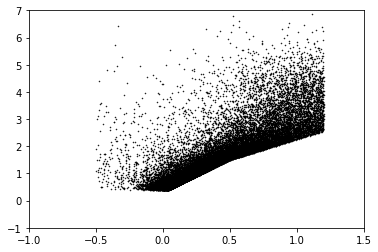

In [33]:
pl.plot(final_tmgs['G'] - final_tmgs['R'], final_tmgs['U'] - final_tmgs['G'], marker='.', lw=0.0, c='k', markersize=1)
pl.xlim(-1., 1.5)
pl.ylim(-1.,  7.)

# Done.